## **Marketing Mix Modelling**

In [34]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
df = pd.read_excel("MMM_data_clean_lastyear.xlsx", parse_dates=["DATE"])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   DATE                                 362 non-null    datetime64[ns]
 1   SALES ($)                            362 non-null    float64       
 2   Advertising Expenses (SMS)           362 non-null    float64       
 3   Advertising Expenses(Newspaper ads)  362 non-null    float64       
 4   Advertising Expenses(Radio)          362 non-null    float64       
 5   Advertising Expenses(TV)             362 non-null    float64       
 6   Advertising Expenses(Internet)       362 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 19.9 KB
None


In [6]:
df.head()

,DATE,SALES ($),Advertising Expenses (SMS),Advertising Expenses(Newspaper ads),Advertising Expenses(Radio),Advertising Expenses(TV),Advertising Expenses(Internet)
0,2016-03-01,2270973.60,72.1521,13.686512,97.1450,1434.9029,3074.667
1,2016-03-02,2256508.80,72.9083,13.361679,102.3750,1442.0250,3117.048
2,2016-03-03,2344020.84,71.8265,13.682436,98.0009,1460.4452,2023.524
3,2016-03-04,2365718.04,70.9562,13.756545,98.7625,1454.8207,3395.667
4,2016-03-05,2082569.58,59.2809,13.217295,84.6320,1392.1066,2921.333


#### **Data Preprocessing**

In [ ]:
#Converting DATE to year-month format
df["year_month"] = df["DATE"].dt.to_period("M")

#Selecting only numeric columns (excluding DATE)
numeric_cols = df.select_dtypes(include=[np.number]).columns

#Aggregating by month 
monthly_df = df.groupby("year_month")[numeric_cols].sum().reset_index()

In [14]:
monthly_df.head()

,SALES ($),Advertising Expenses (SMS),Advertising Expenses(Newspaper ads),Advertising Expenses(Radio),Advertising Expenses(TV),Advertising Expenses(Internet)
year_month,,,,,,
2016-03,63513128.70,1946.0412,412.796851,2608.5144,43208.9687,111117.287
2016-04,61775182.98,1427.4818,346.910789,2352.0578,36140.6166,114137.832
2016-05,58835212.38,1956.8890,390.732497,2912.2416,40876.4958,54983.705
2016-06,63007222.32,2128.0041,403.541055,2935.4881,42530.2218,92381.099
2016-07,67569420.24,1834.1384,406.873956,2447.7711,42446.9731,119064.763


In [ ]:
#Convert back to datetime for easier plotting
monthly_df["year_month"] = monthly_df["year_month"].astype(str)
monthly_df["year_month"] = pd.to_datetime(monthly_df["year_month"])

monthly_df.head()

,year_month,SALES ($),Advertising Expenses (SMS),Advertising Expenses(Newspaper ads),Advertising Expenses(Radio),Advertising Expenses(TV),Advertising Expenses(Internet)
0,2016-03-01,63513128.70,1946.0412,412.796851,2608.5144,43208.9687,111117.287
1,2016-04-01,61775182.98,1427.4818,346.910789,2352.0578,36140.6166,114137.832
2,2016-05-01,58835212.38,1956.8890,390.732497,2912.2416,40876.4958,54983.705
3,2016-06-01,63007222.32,2128.0041,403.541055,2935.4881,42530.2218,92381.099
4,2016-07-01,67569420.24,1834.1384,406.873956,2447.7711,42446.9731,119064.763


#### **Exploratory Data Analysis**

(A) Total Ad Spend vs. Total Sales
<br>
Total Ad spend has a seasonal trend repeating over every 2 months in the same magnitude indicating a static promotions strategy. Total Sales, on the other hand, tends to grow towards the year-end, which can be attributed to to common festivals & holidays in the months of November & December.

In [ ]:
#Computing Total Ad Spend
ad_columns = [
    "Advertising Expenses (SMS)",
    "Advertising Expenses(Newspaper ads)",
    "Advertising Expenses(Radio)",
    "Advertising Expenses(TV)",
    "Advertising Expenses(Internet)"
]
monthly_df["Total_Ad_Spend"] = monthly_df[ad_columns].sum(axis=1, skipna=True)


fig = go.Figure()

#Adding total ad spend (left y-axis)
fig.add_trace(
    go.Scatter(
        x=monthly_df["year_month"],
        y=monthly_df["Total_Ad_Spend"],
        name="Total Ad Spend",
        line=dict(color='blue')
    )
)

#Adding sales (right y-axis)
fig.add_trace(
    go.Scatter(
        x=monthly_df["year_month"],
        y=monthly_df["SALES ($)"],
        name="Sales ($)",
        line=dict(color='orange'),
        yaxis="y2"
    )
)

fig.update_layout(
    title="Monthly Total Ad Spend vs. Sales",
    xaxis=dict(title="Month"),
    yaxis=dict(title="Total Ad Spend", color='blue'),
    yaxis2=dict(
        title="Sales ($)",
        overlaying='y',
        side='right',
        color='orange'
    ),
    legend=dict(x=0.5, xanchor="center", orientation="h"),
    template="plotly_white"
)

fig.show()


(B) Monthly Ad Spend by Channel
<br>
Channels like the Internet & Television dominate the Marketing budgets being as much as 50 times of other channels like SMS & Radio.

In [35]:
df_ad_melted = monthly_df[["year_month"] + ad_columns].melt(id_vars="year_month", 
                                                            var_name="Channel", 
                                                            value_name="Spend")

fig = px.line(df_ad_melted, x="year_month", y="Spend", color="Channel",
              title="Monthly Ad Spend by Channel")
fig.update_layout(xaxis_title="Month", yaxis_title="Spend ($)")
fig.show()

(C) Outlier Detection
<br>
No outliers found in the ad spending of any of the channels, which again indicates a very conservative/ stagnant spending patterns with no past history of optimisation attempts.

In [41]:
px.box(monthly_df[["Advertising Expenses (SMS)", "Advertising Expenses(Newspaper ads)", "Advertising Expenses(Radio)"]])

In [42]:
px.box(monthly_df[[ "Advertising Expenses(TV)", "Advertising Expenses(Internet)"]])

#### **Feature Engineering**

In [18]:
# Select the advertising expense columns
ad_columns = ["Advertising Expenses (SMS)", "Advertising Expenses(Newspaper ads)", 
              "Advertising Expenses(Radio)", "Advertising Expenses(TV)", 
              "Advertising Expenses(Internet)"]

# Apply log transformation
for col in ad_columns:
    monthly_df["log_" + col] = np.log(monthly_df[col] + 1)  # Adding 1 to avoid log(0)

# Check the transformed data
monthly_df.head()


,year_month,SALES ($),Advertising Expenses (SMS),Advertising Expenses(Newspaper ads),Advertising Expenses(Radio),Advertising Expenses(TV),Advertising Expenses(Internet),log_Advertising Expenses (SMS),log_Advertising Expenses(Newspaper ads),log_Advertising Expenses(Radio),log_Advertising Expenses(TV),log_Advertising Expenses(Internet)
0,2016-03-01,63513128.70,1946.0412,412.796851,2608.5144,43208.9687,111117.287,7.574066,6.025375,7.866919,10.673827,11.618351
1,2016-04-01,61775182.98,1427.4818,346.910789,2352.0578,36140.6166,114137.832,7.264367,5.851946,7.763471,10.495200,11.645171
2,2016-05-01,58835212.38,1956.8890,390.732497,2912.2416,40876.4958,54983.705,7.579622,5.970579,7.977022,10.618335,10.914810
3,2016-06-01,63007222.32,2128.0041,403.541055,2935.4881,42530.2218,92381.099,7.663410,6.002753,7.984970,10.657994,11.433689
4,2016-07-01,67569420.24,1834.1384,406.873956,2447.7711,42446.9731,119064.763,7.514875,6.010958,7.803342,10.656034,11.687431


#### **Regression Model Development**

In [ ]:
X = monthly_df[["log_Advertising Expenses (SMS)", "log_Advertising Expenses(Newspaper ads)", 
                "log_Advertising Expenses(Radio)", "log_Advertising Expenses(TV)", 
                "log_Advertising Expenses(Internet)"]]

#Adding intercept
X = sm.add_constant(X)

y = monthly_df["SALES ($)"]

In [ ]:
#Training the model
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              SALES ($)   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     1.368
Date:                Tue, 13 May 2025   Prob (F-statistic):              0.353
Time:                        23:16:08   Log-Likelihood:                -202.53
No. Observations:                  12   AIC:                             417.1
Df Residuals:                       6   BIC:                             420.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)


Note : p-values of all coefficients are slightly higher than the 95% significance borderline. This may be due to,
- the small size of the dataset
- inadequacy of the Regression Model to capture the non-linear relationships between the variables

Hence, we won't be disregrading them and will be using all the co-efficients to ascertain spend optimisation. This comes with slightly higher risk of the reliability of the optimisation solution, but the said risk can be minimised by validating the solution with domain knowledge.

In [ ]:
coefficients = model.params.drop("const")  

#Computing ROI per channel
roi_per_channel = coefficients.sort_values(ascending=False)

print("Estimated ROI per Channel:")
print(roi_per_channel)


Estimated ROI per Channel:
log_Advertising Expenses(Newspaper ads)    5.659060e+09
log_Advertising Expenses (SMS)             4.004545e+08
log_Advertising Expenses(Radio)            1.319129e+08
log_Advertising Expenses(Internet)         8.218877e+07
log_Advertising Expenses(TV)              -6.263863e+09
dtype: float64


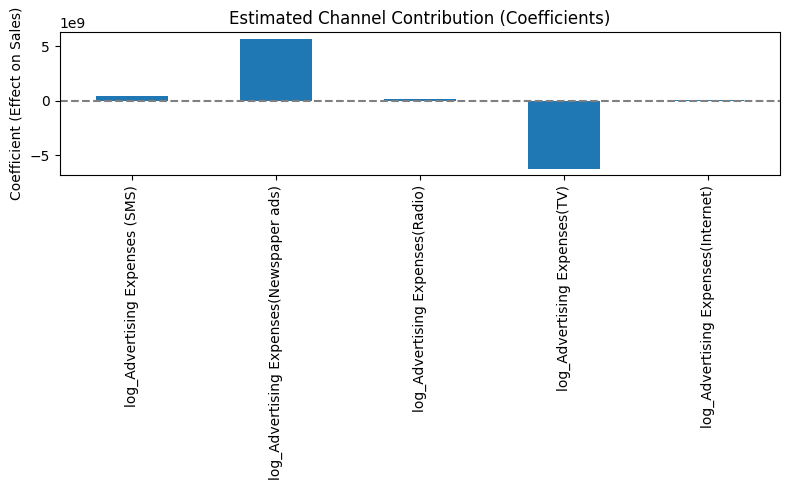

In [45]:
#plotting the coefficients for better visualisation
coefficients.plot(kind='bar', figsize=(8, 5), title="Estimated Channel Contribution (Coefficients)")
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("Coefficient (Effect on Sales)")
plt.tight_layout()
plt.show()


#### **Ad Spend Optimisation**

In [22]:
def objective(spend):
    spend_SMS, spend_Newspaper, spend_Radio, spend_TV, spend_Internet = spend
    
    predicted_sales = (model.params["const"] +
                       model.params["log_Advertising Expenses (SMS)"] * np.log(spend_SMS + 1) +
                       model.params["log_Advertising Expenses(Newspaper ads)"] * np.log(spend_Newspaper + 1) +
                       model.params["log_Advertising Expenses(Radio)"] * np.log(spend_Radio + 1) +
                       model.params["log_Advertising Expenses(TV)"] * np.log(spend_TV + 1) +
                       model.params["log_Advertising Expenses(Internet)"] * np.log(spend_Internet + 1))
    
    return -predicted_sales  # Minimize negative sales to maximize actual sales


In [ ]:
#defining total budget available
total_budget = 136000  

constraints = ({'type': 'eq', 'fun': lambda x: sum(x) - total_budget})

#defining Initial guess
initial_guess = [total_budget / 5] * 5

#defining bounds per channel
bounds = [(5000, 40000)] * 5 


optimal_allocation = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)


optimal_spend = optimal_allocation.x
print(f"Optimal SMS Spend: ${optimal_spend[0]:,.2f}")
print(f"Optimal Newspaper Spend: ${optimal_spend[1]:,.2f}")
print(f"Optimal Radio Spend: ${optimal_spend[2]:,.2f}")
print(f"Optimal TV Spend: ${optimal_spend[3]:,.2f}")
print(f"Optimal Internet Spend: ${optimal_spend[4]:,.2f}")


Optimal SMS Spend: $37,245.26
Optimal Newspaper Spend: $39,996.61
Optimal Radio Spend: $28,029.26
Optimal TV Spend: $5,003.61
Optimal Internet Spend: $25,725.26


In [49]:
channels = ["SMS", "Newspaper", "Radio", "TV", "Internet"]
df_budget = pd.DataFrame({
    "Channel": channels,
    "Current Spend": current_spend,
    "Optimal Spend": optimal_spend
})

df_budget_melted = df_budget.melt(id_vars="Channel", var_name="Type", value_name="Spend")

fig = px.bar(df_budget_melted, x="Channel", y="Spend", color="Type", barmode="group",
             title="Current vs. Optimal Budget Allocation")
fig.update_layout(yaxis_title="Spend ($)")
fig.show()
